In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs) #preferences and font stuff.
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

#import warnings
#warnings.filterwarnings('ignore')
#from IPython.display import Markdown, display

%matplotlib inline

/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:46: UserWarning: Neither Python Excel module ('openpyxl','xlrd') found
  warnings.warn("Neither Python Excel module ('openpyxl','xlrd') found",UserWarning)


In [2]:
year=2011
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [3]:
display(Markdown('''## Year: '''+ str(year)))

NameError: name 'Markdown' is not defined

In [4]:
display(Markdown('''### Model output: '''+ PATH))

NameError: name 'Markdown' is not defined

## Yearly model-data comparisons of nutrients, chlorophyll, temperature and salinity between 201905 runs and WADE observations

### load observations

In [5]:
dfSta=pickle.load(open(os.path.join(datadir,'sta_df.p'),'rb')) # a list of the stations.
# note that os.path is just a convenient way to connect directory/file names into a path. 

In [6]:
dfSta.head()

,Desig,Descrip,Basin,Max_Depth,Latitude,Longitude
Station,,,,,,
ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933
ADM002,C,Admiralty Inlet (north) - Quimper Pn.,Admiralty Inlet,79,48.187318,-122.842950
ADM003,C,Admiralty Inlet (south),Admiralty Inlet,118,47.878983,-122.483195
BLL009,C,Bellingham Bay - Pt. Frances,Strait of Georgia,31,48.685940,-122.599618
BUD005,C,Budd Inlet - Olympia Shoal,South Basin,22,47.092040,-122.918197


In [7]:
dfBot=pickle.load(open(os.path.join(datadir,f'Bottles_{str(year)}.p'),'rb')) #the actual observed statistics. 

In [8]:
dfBot.head()

,Station,Date,UTCDateTime,Z,PO4(uM)D,SiOH4(uM)D,NO3(uM)D,NO2(uM)D,NH4(uM)D,DIN,Znom
0,ADM001,2011-01-04,2011-01-04 19:11:00.000004,-29.576,2.341510,56.240047,26.851263,0.130560,0.000000,26.981823,-30.0
1,ADM001,2011-01-04,2011-01-04 19:11:00.000004,-9.464,2.381048,58.035976,27.258053,0.123800,0.000000,27.381852,-10.0
2,ADM001,2011-01-04,2011-01-04 19:11:00.000004,-0.816,2.373680,58.623909,27.312132,0.124044,0.000000,27.436176,-0.0
3,ADM001,2011-03-07,2011-03-07 18:09:59.999996,-10.310,2.314797,59.918163,28.142775,0.201250,0.148276,28.492300,-10.0
4,ADM001,2011-03-07,2011-03-07 18:09:59.999996,-1.104,2.294059,59.969868,27.972746,0.197206,0.116664,28.286616,-0.0


In [9]:
df1=pd.merge(left=dfSta,right=dfBot,how='right',
             left_on='Station',right_on='Station')# this tells us to join station with station, specifies the keys so that it does not choose everykey to join. 
#right join means all rows in right table (dfBot) are included in output
df1.head()

,Station,Desig,Descrip,Basin,Max_Depth,Latitude,Longitude,Date,UTCDateTime,Z,PO4(uM)D,SiOH4(uM)D,NO3(uM)D,NO2(uM)D,NH4(uM)D,DIN,Znom
0,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2011-01-04,2011-01-04 19:11:00.000004,-29.576,2.341510,56.240047,26.851263,0.130560,0.000000,26.981823,-30.0
1,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2011-01-04,2011-01-04 19:11:00.000004,-9.464,2.381048,58.035976,27.258053,0.123800,0.000000,27.381852,-10.0
2,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2011-01-04,2011-01-04 19:11:00.000004,-0.816,2.373680,58.623909,27.312132,0.124044,0.000000,27.436176,-0.0
3,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2011-03-07,2011-03-07 18:09:59.999996,-10.310,2.314797,59.918163,28.142775,0.201250,0.148276,28.492300,-10.0
4,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2011-03-07,2011-03-07 18:09:59.999996,-1.104,2.294059,59.969868,27.972746,0.197206,0.116664,28.286616,-0.0


In [10]:
# check that there are no stations without lat and lon
df1.loc[pd.isnull(df1['Latitude'])] #seeing if there are any null values in latitude. 

,Station,Desig,Descrip,Basin,Max_Depth,Latitude,Longitude,Date,UTCDateTime,Z,PO4(uM)D,SiOH4(uM)D,NO3(uM)D,NO2(uM)D,NH4(uM)D,DIN,Znom


In [11]:
#check on to one matches:
len(df1),len(dfBot), len(dfSta) # a great way to make sure everything worked, if df1 and dfBot were different it would be a problem.

(778, 778, 39)

In [12]:
# where no time is provided, set time to midday Pacific time = ~ 20:00 UTC for now
# (most sampling takes place during the day)
# accurate times will be provided at a later date
# the code below takes advantage of all elements in 'Date' having a time component 
# set to midnight
df1['UTCDateTime']=[iiD+dt.timedelta(hours=20) if pd.isnull(iiU) \
                    else iiU for iiU,iiD in \
                    zip(df1['UTCDateTime'],df1['Date'])]

In [13]:
# We require the following columns:
#    dtUTC datetime
#    Lat   Latitude
#    Lon   Longitude
#    Z     Depth, increasing downward (positive)
df1.rename(columns={'UTCDateTime':'dtUTC','Latitude':'Lat','Longitude':'Lon'},inplace=True)
df1['Z']=-1*df1['Z']#switching depth from negative numbers to positive numbers.
df1.head() #just renaming. 

,Station,Desig,Descrip,Basin,Max_Depth,Lat,Lon,Date,dtUTC,Z,PO4(uM)D,SiOH4(uM)D,NO3(uM)D,NO2(uM)D,NH4(uM)D,DIN,Znom
0,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2011-01-04,2011-01-04 19:11:00.000004,29.576,2.341510,56.240047,26.851263,0.130560,0.000000,26.981823,-30.0
1,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2011-01-04,2011-01-04 19:11:00.000004,9.464,2.381048,58.035976,27.258053,0.123800,0.000000,27.381852,-10.0
2,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2011-01-04,2011-01-04 19:11:00.000004,0.816,2.373680,58.623909,27.312132,0.124044,0.000000,27.436176,-0.0
3,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2011-03-07,2011-03-07 18:09:59.999996,10.310,2.314797,59.918163,28.142775,0.201250,0.148276,28.492300,-10.0
4,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2011-03-07,2011-03-07 18:09:59.999996,1.104,2.294059,59.969868,27.972746,0.197206,0.116664,28.286616,-0.0


In [14]:
# It will also be useful to add/rename the following columns:
df1['NO23']=df1['NO3(uM)D']+df1['NO2(uM)D'] # the model does not distinguish between NO2 and NO3
df1['Amm']=df1['NH4(uM)D']
df1['Si']=df1['SiOH4(uM)D']
df1['Year']=[ii.year for ii in df1['dtUTC']]
df1['YD']=et.datetimeToYD(df1['dtUTC'])

In [15]:
print(len(df1),'data points')
print('Number of data points in each region:')
df1.groupby('Basin')['NO23'].count() #anything could go inplace of NO23 really. 

778 data points
Number of data points in each region:


Basin
Admiralty Inlet       86
Grays Harbor          49
Hood Canal Basin     105
Main Basin           148
South Basin          195
Strait of Georgia     50
Whidbey Basin         57
Willapa Bay           88
Name: NO23, dtype: int64

### set up variables for model-data matching

In [16]:
start_date = dt.datetime(year,1,1)
end_date = dt.datetime(year,12,31)
flen=1 #number of days of model output contained in an output file.
namfmt='nowcast'
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T',
         'ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
fdict={'ptrc_T':1,'grid_T':1}

What are all of these grids and ptrcs and Ts and what is tmask?

In [17]:
data=et.matchData(df1,filemap,fdict,start_date,end_date,'nowcast',PATH,1,quiet=False);

(Lat,Lon)= 46.54537666666667 -123.98016166666666  not matched to domain
(Lat,Lon)= 46.644 -123.993  not matched to domain
(Lat,Lon)= 46.68676333333333 -123.9735  not matched to domain
(Lat,Lon)= 46.68732166666667 -123.74988166666667  not matched to domain
(Lat,Lon)= 46.703986666666665 -123.837385  not matched to domain
(Lat,Lon)= 46.937313333333336 -123.91322333333333  not matched to domain
(Lat,Lon)= 46.953421666666664 -124.09295  not matched to domain
(Lat,Lon)= 46.97787 -123.78461  not matched to domain
(Lat,Lon)= 47.21342666666666 -123.07765  not matched to domain


Here is all the data for the shape of the bottom of the model. 

In [18]:
data.dtUTC

0     2011-01-04 17:44:00.000001
1     2011-01-04 17:44:00.000001
2     2011-01-04 17:44:00.000001
3     2011-01-04 18:29:00.000001
4     2011-01-04 18:29:00.000001
                 ...            
616   2011-12-21 21:04:59.999998
617   2011-12-21 21:04:59.999998
618   2011-12-21 22:00:00.000003
619   2011-12-21 22:00:00.000003
620   2011-12-21 22:00:00.000003
Name: dtUTC, Length: 621, dtype: datetime64[ns]

In [19]:
cm1=cmocean.cm.thermal #What is this up to?
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

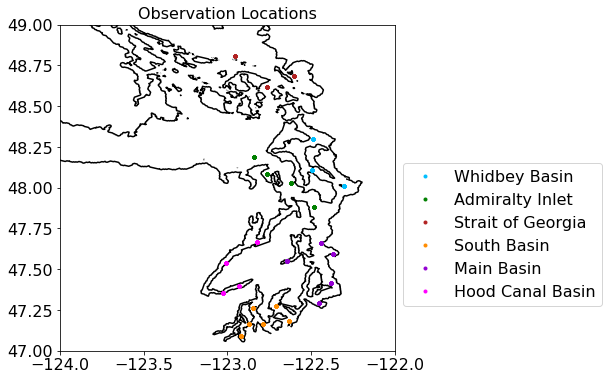

In [20]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid: #you will get data from somewhere else.
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)# cannot set isobath to zero. I wonder what happens when set to grid.
colors=('deepskyblue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','teal')
datreg=dict()# This whole datreg thing does something I do not quite understand. I think it is just the data by region which is probably what it stands for.
for ind, iregion in enumerate(data.Basin.unique()): #gives a list of unique values present in column So that each basin has its own color. 
    datreg[iregion] = data.loc[data.Basin==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0]) #what is going on here???
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

iz=(data.Z<15) #What was the point of all of this again?
JFM=data.loc[iz&(data.dtUTC<=dt.datetime(year,4,1)),:]
Apr=data.loc[iz&(data.dtUTC<=dt.datetime(year,5,1))&(data.dtUTC>dt.datetime(year,4,1)),:] #why does april have its own section.
MJJA=data.loc[iz&(data.dtUTC<=dt.datetime(year,9,1))&(data.dtUTC>dt.datetime(year,5,1)),:]
SOND=data.loc[iz&(data.dtUTC>dt.datetime(year,9,1)),:]

In [21]:
def byDepth(ax,obsvar,modvar,lims):
    ps=et.varvarPlot(ax,data,obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
    l=ax.legend(handles=ps)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)# What does set aspect do?
    return ps,l

def byRegion(ax,obsvar,modvar,lims,sep = False,region = 'not'):
    ps=[]
    if sep == False:
        for ind, iregion in enumerate(data.Basin.unique()):
            ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
                    color = colors[ind], label=iregion)
            ps0=et.varvarPlot(ax,datreg[iregion],obsvar,modvar,
                              cols=(colors[ind],),lname=iregion)
            ps.append(ps0)
    elif sep == True:
        ax.plot(datreg[region]['Lon'], datreg[region]['Lat'],'.',
                    color = colors[np.random.randint(0,10)], label=region)
        ps0=et.varvarPlot(ax,datreg[region],obsvar,modvar,
                          cols=(colors[np.random.randint(0,10)],),lname=region)
        ps.append(ps0)
    l=ax.legend(handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    ps=et.varvarPlot(ax[0],JFM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Jan-Mar')
    ps=et.varvarPlot(ax[1],Apr,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Apr')
    ps=et.varvarPlot(ax[2],MJJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('May-Aug')
    ps=et.varvarPlot(ax[3],SOND,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Sep-Dec')
    return 

def ErrErr(fig,ax,obsvar1,modvar1,obsvar2,modvar2,lims1,lims2):
    m=ax.scatter(data[modvar1]-data[obsvar1],data[modvar2]-data[obsvar2],c=data['Z'],s=1,cmap='gnuplot')
    cb=fig.colorbar(m,ax=ax,label='Depth (m)')
    ax.set_xlim(lims1)
    ax.set_ylim(lims2)
    ax.set_aspect((lims1[1]-lims1[0])/(lims2[1]-lims2[0]))
    return m,cb
# all of these in some way or the other call to the full dataset itself. 

In [22]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                      '15 m < z < 22 m':data.loc[(data.Z>=15)&(data.Z<22)],
                      'z >= 22 m':data.loc[data.Z>=22],
                      'z > 50 m':data.loc[data.Z>50],
                      'all':data,
                      'z < 15 m, JFM':JFM,
                      'z < 15 m, Apr':Apr,
                      'z < 15 m, MJJA':MJJA,
                      'z < 15 m, SOND': SOND,})
for iregion in data.Basin.unique():
    statsubs[iregion]=datreg[iregion]
statsubs.keys()

odict_keys(['z < 15 m', '15 m < z < 22 m', 'z >= 22 m', 'z > 50 m', 'all', 'z < 15 m, JFM', 'z < 15 m, Apr', 'z < 15 m, MJJA', 'z < 15 m, SOND', 'Whidbey Basin', 'Admiralty Inlet', 'Strait of Georgia', 'South Basin', 'Main Basin', 'Hood Canal Basin'])

# Nitrate

### <font color="cyan"> So this is where statsDict starts. It is an empty dictionary that she slowly fills up with information. Also, Stats subs is a bunch of views of the data itself, so that is where all the data is coming from in these next couple of parts. Also deframe is just responsible for finding that the name is something witin a dataframe and then flattens that dataframe. </font>

In [23]:
obsvar='NO23'
modvar='mod_nitrate'
statsDict={year:dict()} 
statsDict[year]['NO3']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['NO3'][isub]=dict()
    var=statsDict[year]['NO3'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],#ET stats just spits out a bunch of statistics, I wish it was more clear about the order it releases them in
                                                                     statsubs[isub].loc[:,[modvar]]) #here is where modvar comes into the mix.
tbl,tdf=et.displayStats(statsDict[year]['NO3'],level='Subset',suborder=list(statsubs.keys())) #what does et.displayStats do. 
tbl

z < 15 m
15 m < z < 22 m
z >= 22 m
z > 50 m
all
z < 15 m, JFM
z < 15 m, Apr
z < 15 m, MJJA
z < 15 m, SOND
Whidbey Basin
Admiralty Inlet
Strait of Georgia
South Basin
Main Basin
Hood Canal Basin


/home/kflanaga/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kflanaga/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1136: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(np.sum((mod-obs)**2)/len(mod))
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1132: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-np.mean(obs))+np.abs(obs-np.mean(obs)))**2)


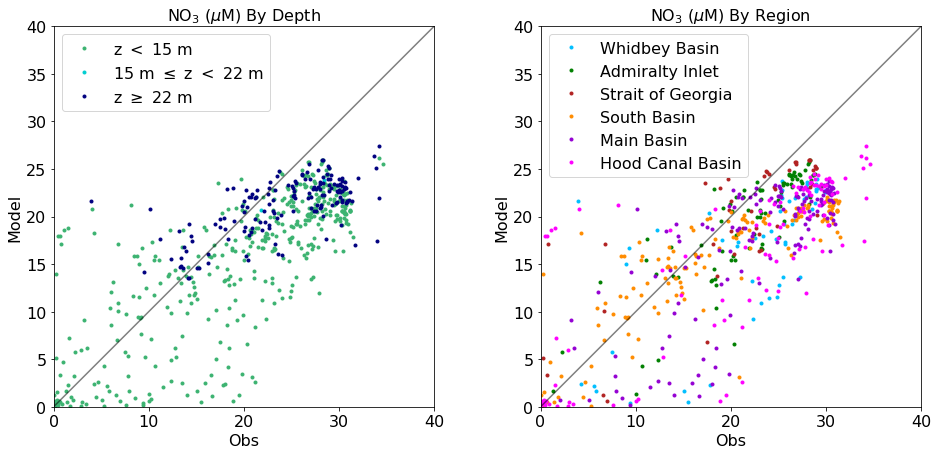

In [24]:
fig, ax = plt.subplots(1,2,figsize = (16,7))#set the number of plots and the size and make them equal to fig and ax
ps,l=byDepth(ax[0],obsvar,modvar,(0,40)) # use ax to fill up the graph. 
ax[0].set_title('NO$_3$ ($\mu$M) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(0,40))
ax[1].set_title('NO$_3$ ($\mu$M) By Region'); #hmmm what does ; do in Python in this context. 

<font color = "cyan"> Why is it that the results from hood canal seem so much more spread out even though they are also very centered (low bias, high WSS?) Is there a common sort of cause for this anomaly?</font>

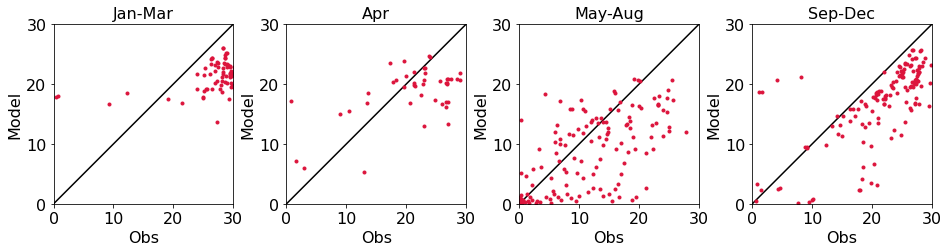

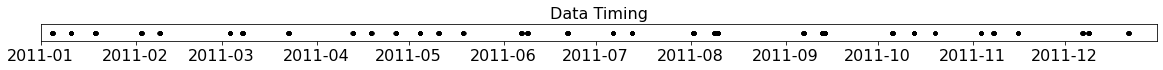

In [25]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3)) # This does all of the little plots. 
bySeason(ax,obsvar,modvar,(0,30))
fig,ax=plt.subplots(1,1,figsize=(20,.3)) # This does the weird thing on the bottom.
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

# Dissolved Silica

In [26]:
obsvar='Si'
modvar='mod_silicon'
statsDict[year]['dSi']=OrderedDict()
for isub in statsubs:
    statsDict[year]['dSi'][isub]=dict()
    var=statsDict[year]['dSi'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]], #how does this actually call to the dataframes themselves?
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['dSi'],level='Subset',suborder=list(statsubs.keys()))
tbl

/home/kflanaga/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kflanaga/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1136: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(np.sum((mod-obs)**2)/len(mod))
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1132: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-np.mean(obs))+np.abs(obs-np.mean(obs)))**2)


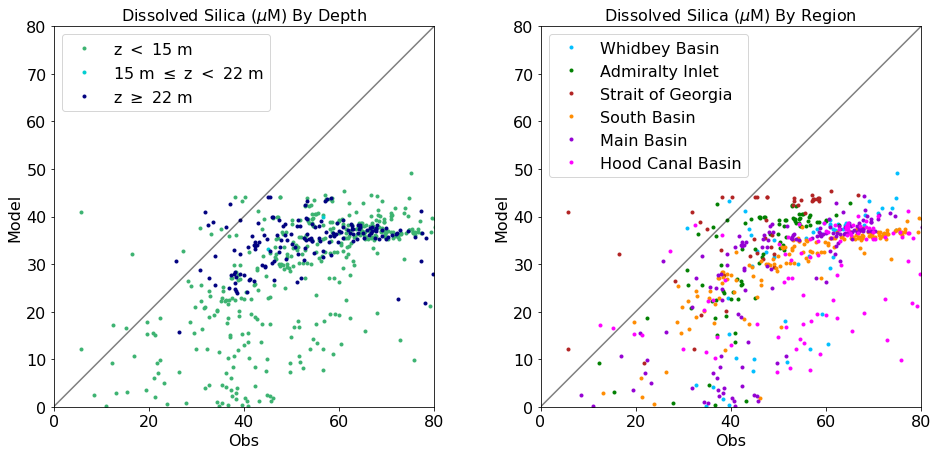

In [27]:
mv=(0,80)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,mv)
ax[0].set_title('Dissolved Silica ($\mu$M) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,mv)
ax[1].set_title('Dissolved Silica ($\mu$M) By Region');

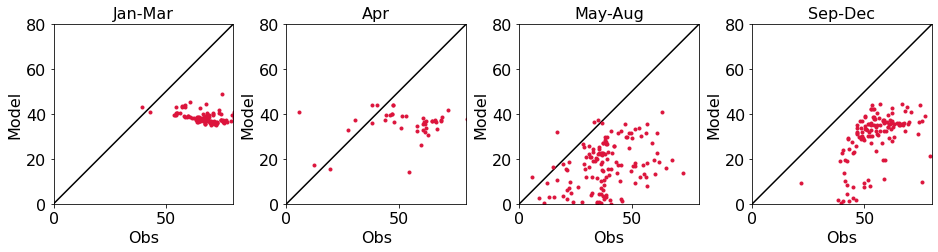

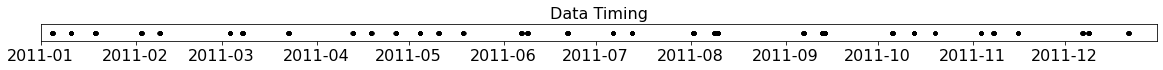

In [89]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Profiles of NO3 and Dissolved Silica

<font color="cyan"> Hmmm. This little section below me shows that I still have a lot to study with this. Both the depth plots and the comparison plots

<font color="cyan"> I think the colours are meant to represent different months, like 0 is January and 11 is December. That is probably related to all the other stuff I do not understand about this </font>

Text(0.5, 1.0, 'dSi')

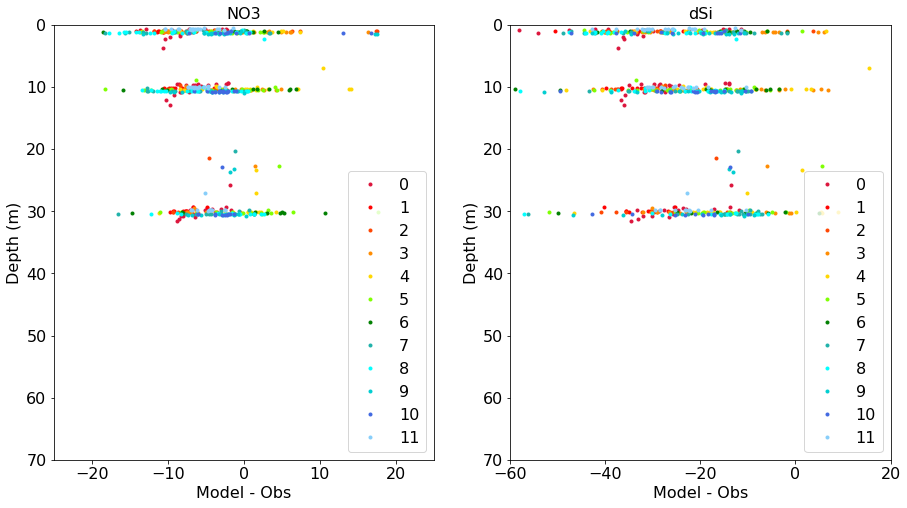

In [90]:
fig, ax = plt.subplots(1,2,figsize = (15,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'darkturquoise','royalblue','lightskyblue','blue','darkblue','mediumslateblue','blueviolet',
      'darkmagenta','fuchsia','deeppink','pink')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,['NO23']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,['Si']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(70,0)
    axi.set_ylabel('Depth (m)')
ax[0].set_xlabel('Model - Obs')
ax[1].set_xlabel('Model - Obs')
ax[0].set_xlim(-25,25)
ax[1].set_xlim(-60,20)
ax[0].set_title('NO3')
ax[1].set_title('dSi')

# dSi:NO3 Ratios

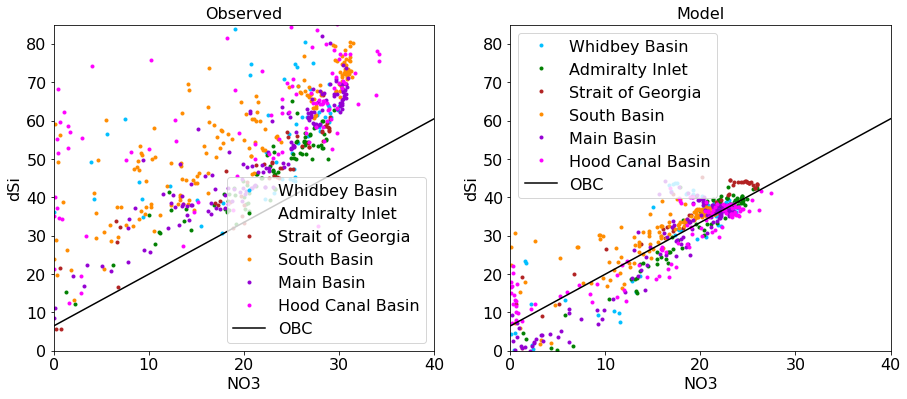

In [91]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
for ind,iregion in enumerate(data.Basin.unique()): # I need more info on enumerate.
    p1=ax[0].plot(datreg[iregion]['NO23'],datreg[iregion]['Si'],'.', #I guess you cannot use byRegion here.
                  color=colors[ind],label=iregion) #this for loop takes all of the different basin names and uses that to call the necessary information out of datreg I think ind is something we set up while making the map. 
ax[0].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC') # This just creates the correlation line needed for these kinds of plots, but what does OBC stand for and where did these numbers come from?
ax[0].set_title('Observed')
ax[0].set_xlabel('NO3')
ax[0].set_ylabel('dSi')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,85)
ax[0].legend()

for ind,iregion in enumerate(data.Basin.unique()):
    p=ax[1].plot(datreg[iregion]['mod_nitrate'],datreg[iregion]['mod_silicon'],'.',
                  color=colors[ind],label=iregion)
ax[1].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')
ax[1].set_title('Model')
ax[1].set_xlabel('NO3')
ax[1].set_ylabel('dSi')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,85)
ax[1].legend()
#ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
#ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

Note the close correlation between nitrate and silicon in the model. In puget sound, the ratios is based on silicate brought in by the rivers (most likely) so it is reasonable that it might look like this. 

<font color="cyan"> I also notice that South Basin is particularly far from the model. Is this because that region has extra rivers? Hmmmm. Hood Canal Basin is also very far from the model. Could it have something do with the fact that hood and puget are both shallower and narrower? </font> 

# NH4

These first parts are all about creating tables, and have basically nothing to do with the graphing

In [92]:
obsvar='Amm'
modvar='mod_ammonium'
statsDict[year]['NH4']=OrderedDict()
for isub in statsubs:
    statsDict[year]['NH4'][isub]=dict()
    var=statsDict[year]['NH4'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['NH4'],level='Subset',suborder=list(statsubs.keys()))
tbl

/home/kflanaga/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kflanaga/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1136: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(np.sum((mod-obs)**2)/len(mod))
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1132: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-np.mean(obs))+np.abs(obs-np.mean(obs)))**2)


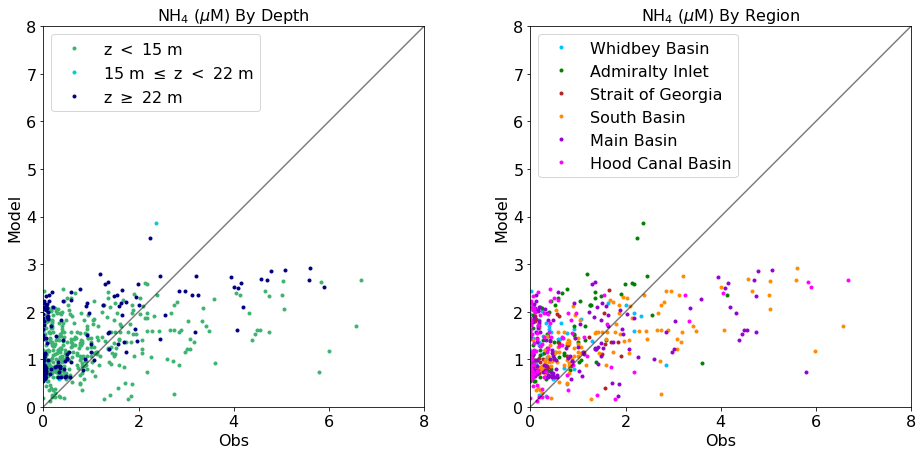

In [93]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(0,8))
ax[0].set_title('NH$_4$ ($\mu$M) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(0,8))
ax[1].set_title('NH$_4$ ($\mu$M) By Region');

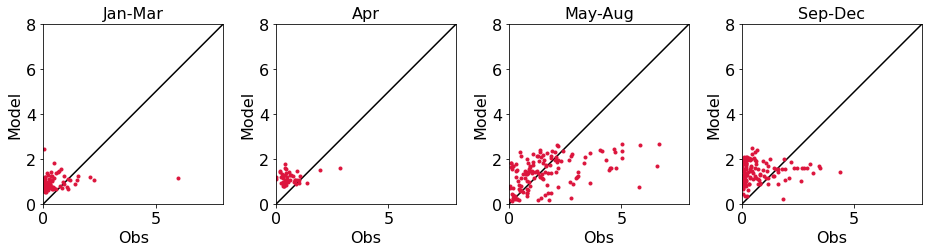

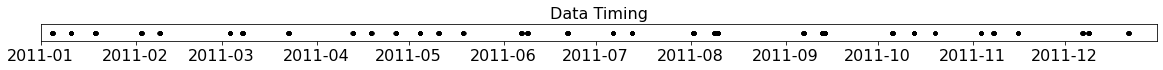

In [94]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,(0,8))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Does model ammonium depend strongly on model salinity? 
### Does the residual of (model-obs ammonium) depend on model salinity?

Perhaps a question for me for later.

<font color="cyan"> Why did they choose salinity for this question? Is something like temperature less important for ammonium? Does it have something to do with the fact that model seems to get progressively worse as the year goes on?</font>

## A Summary table of all the variables of interest

In [28]:
tbl,tdf=et.displayStats(statsDict[year],level='Variable',suborder=list(statsubs.keys()))
tbl

## Keegan's Practice session

In [95]:
def diff_by_env(ax,obsvar,modvar,envvar,lname,limx,limy):
    ''' add scatter plot to axis with the difference between a df[obsvar] minus 
        df[modvar] on the x-axis and a environmental variable[envvar] on the y-axis 
    '''
    ps=[]
    obs0=et._deframe(data[obsvar])
    mod0=et._deframe(data[modvar])
    diff0=obs0-mod0
    envvar0=et._deframe(data[envvar])
    ps.append(ax.plot(diff0,envvar0,'.',color=cols[0],label=lname)) #need to look deeper into how ps.append works.
    ax.set_xlabel(f"Difference in {obsvar} (observed - model)")
    ax.set_ylabel(f"{envvar}")
    ax.set_xlim(limx)
    ax.set_ylim(limy)
    return(ps)

Text(0.5, 1.0, 'dNO23 ($\\mu$M) Difference by Depth')

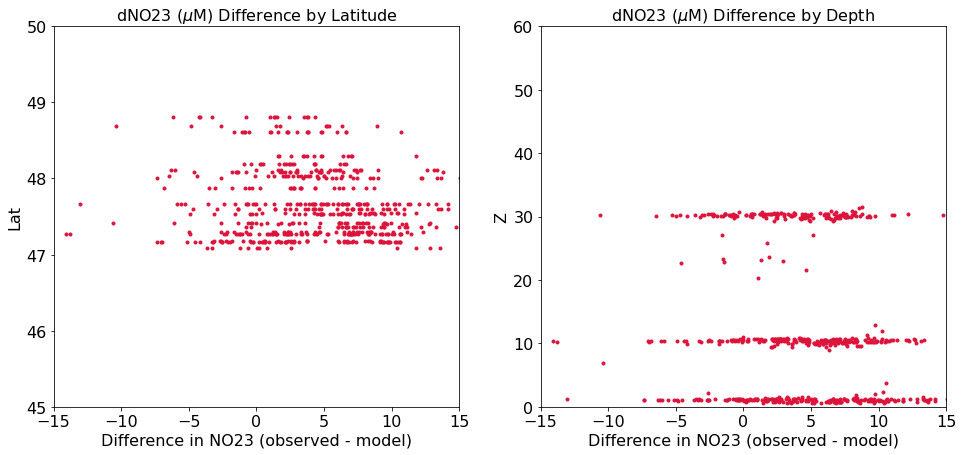

In [96]:
obsvar='NO23'
modvar='mod_nitrate'
envvar='Lat'

fig, ax = plt.subplots(1,2,figsize = (16,7))
ps=diff_by_env(ax[0],obsvar,modvar,envvar,lname="test",limx=(-15,15),limy=(45,50)) #ps is the important stuff. L is just the legend which I probably do not need right now.
ax[0].set_title(f'd{obsvar} ($\mu$M) Difference by Latitude')

envvar='Z'
ps=diff_by_env(ax[1],obsvar,modvar,envvar,lname="test",limx=(-15,15),limy=(0,60)) #ps is the important stuff. L is just which I probably do not need right now.
ax[1].set_title(f'd{obsvar} ($\mu$M) Difference by Depth')

#ps,l=byDepth(ax[1],obsvar,modvar,(0,80))
#ax[1].set_title('NH$_4$ ($\mu$M) By Depth');

### This is just a little section devoted to being able to see each area individually

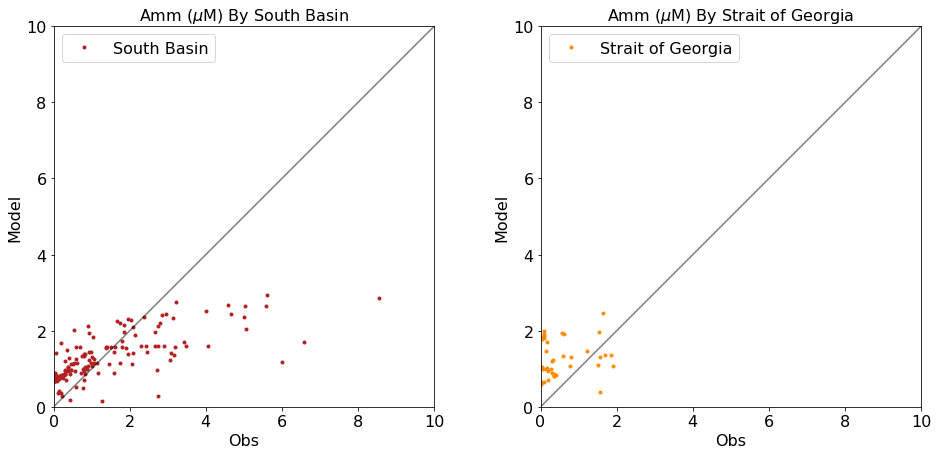

In [97]:
obsvar='Amm'
modvar='mod_ammonium'

fig, ax = plt.subplots(1,2,figsize = (16,7))
region="South Basin"
ps=byRegion(ax[0],obsvar,modvar,(0,10),sep=True,region=region)
ax[0].set_title(f'{obsvar} ($\mu$M) By {region}');

region="Strait of Georgia"
ps=byRegion(ax[1],obsvar,modvar,(0,10),sep=True,region=region)
ax[1].set_title(f'{obsvar} ($\mu$M) By {region}');

The observed Ammonium is a lot less in the straight of georgia then it is in the South Basin, but the model does not seem to pick up on this at all and the spread of values stays pretty consistent across the two areas. This problem is present in many of the basins, so the model could be missing some difference between the basins.

In [98]:
data.columns

Index(['Station', 'Desig', 'Descrip', 'Basin', 'Max_Depth', 'Lat', 'Lon',
       'Date', 'dtUTC', 'Z', 'PO4(uM)D', 'SiOH4(uM)D', 'NO3(uM)D', 'NO2(uM)D',
       'NH4(uM)D', 'DIN', 'Znom', 'NO23', 'Amm', 'Si', 'Year', 'YD', 'j', 'i',
       'mod_nitrate', 'mod_silicon', 'mod_ammonium', 'mod_diatoms',
       'mod_ciliates', 'mod_flagellates', 'mod_vosaline', 'mod_votemper', 'k'],
      dtype='object')